# Script for CHM data preprocessing. 

## Imports and Paths definitons
watch out: data is not pushed to git. check that you have downloaded the raw data in the folder structure and named accordingly 

In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')

from utils import *
from utils import basics as bsc

import importlib
importlib.reload(bsc)


%load_ext autoreload
%autoreload 2



In [2]:
# PATH - Definitions
# === INPUT Paths ===

ALS_PATH1 = '../data/01_input/ALS_GT01_2024.tif' # Ebrach
ALS_PATH2 = '../data/01_input/ALS_GT02_2024.tif' # Waldbrunn
S2_PATH1 = '../data/01_input/S2_Summer_Median' # S2 Summer Median

# ALS_PATH1_P = '../data/02_processed/ALS_GT01_2024_processed.tif' # Ebrach processed; we'll create this here
# ALS_PATH2_P = '../data/02_processed/ALS_GT02_2024_processed.tif' # Waldbrunn processed; we'll create this here

# === OUTPUT Paths ===
OUTPUT_FOLDER = "../data/02_processed"
VRT_FOLDER =  "../data/02_processed/S2_VRT"  
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(VRT_FOLDER, exist_ok=True)
# To reference a file in a sibling folder (e.g., 'data') from the current folder (e.g., 'processing'), use:
# '../data/filename.ext'


## ALS data ingest and Preprocessing

### Raw Data checking

In [3]:
def plot_ALS_histogram(als_path):
    """
    Plot histogram of ALS data.
    """
    # plot histogram of ALS data
    with rasterio.open(als_path) as src:
        als_data = src.read(1).astype(np.float32)

    # === Mask out nodata and NaNs (e.g., 0 or -9999 can be nodata in ALS)
    als_data = als_data[~np.isnan(als_data)]
    # als_data = als_data[als_data <=120]  # optional: remove zeroes if they're nodata
    # als_data = als_data[als_data >= 0]  # optional: filter a known nodata

    # === Plot histogram ===
    percentiles = [0,5,10,90, 95, 97.5, 98, 99, 100]
    #cbar = 
    values = als_data
    perc_values = np.percentile(values, percentiles)

    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=256, color='skyblue', edgecolor='black', alpha=0.7)
    for p, v in zip(percentiles, perc_values):
        plt.axvline(v, color='r', linestyle='--', label=f'{p}th: {v:.1f} m')
    plt.title("ALS Pixel Value Histogram with Percentiles")
    plt.xlabel("Canopy Height (m)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

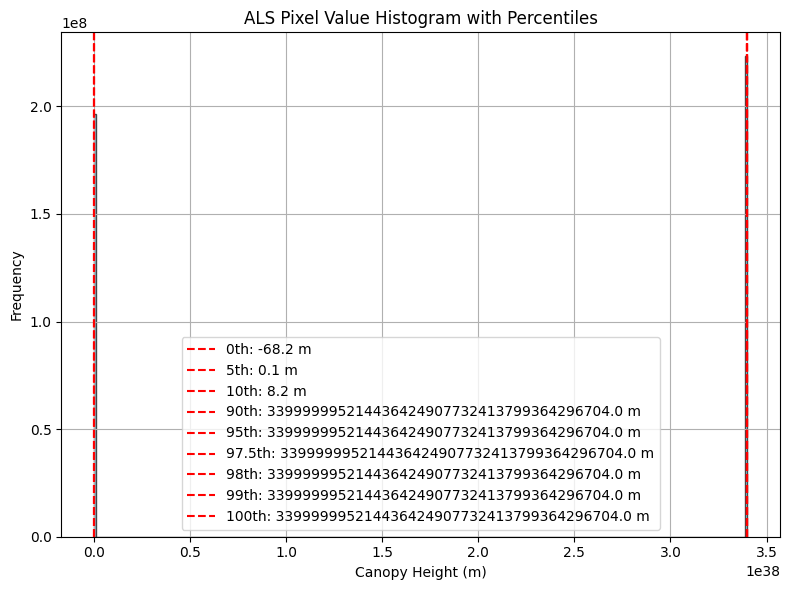

In [4]:
plot_ALS_histogram(ALS_PATH1)

--> we see: negative value and some vast majority of really big numbers. this needs some cleanup first.

### ALS outlier removal

In [7]:
def clean_als_tif(input_path, output_path, min_value=0, max_value=75, override=False):
    """
    Cleans an ALS .tif file by setting values outside [min_value, max_value] to NaN and saves the result.

    Args:
        input_path (str): Path to the raw ALS .tif file.
        output_path (str): Path to save the cleaned .tif file.
        min_value (float): Minimum allowed value; deafults to 0.
        max_value (float): Maximum allowed value; defaults to 75.
    """
    # Extract the base filename without extension and append '_processed.tif'
    base_name = os.path.splitext(os.path.basename(input_path))[0]
    processed_tif_path = os.path.join(output_path, f"{base_name}_processed.tif")

    # Check if the output file already exists
    if os.path.exists(processed_tif_path) and not override:
        print(f"✅  Output file already exists: {processed_tif_path}. Use override=True to overwrite.")
        return processed_tif_path

    with rasterio.open(input_path) as src:
        als_data = src.read(1).astype(np.float32)
        profile = src.profile

    als_data = np.where((als_data < min_value) | (als_data > max_value), np.nan, als_data)
    profile.update(dtype=rasterio.float32, nodata=np.nan)
    # Save the processed data back to a new TIFF file


    with rasterio.open(processed_tif_path, 'w', **profile) as dst:
        dst.write(als_data, 1)

    print(f"✅ Processed TIFF saved to: {processed_tif_path}")
    return processed_tif_path

In [8]:
ALS_PATH1_P = clean_als_tif(ALS_PATH1, OUTPUT_FOLDER)
ALS_PATH2_P = clean_als_tif(ALS_PATH2, OUTPUT_FOLDER)

✅  Output file already exists: ../data/02_processed/ALS_GT01_2024_processed.tif. Use override=True to overwrite.
✅  Output file already exists: ../data/02_processed/ALS_GT02_2024_processed.tif. Use override=True to overwrite.


### Histogram after outlier filtering: looks much better :)

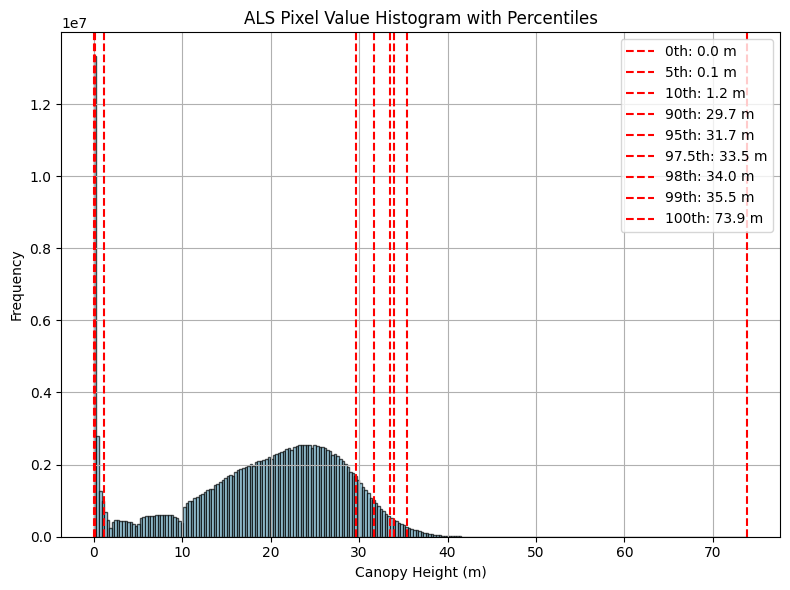

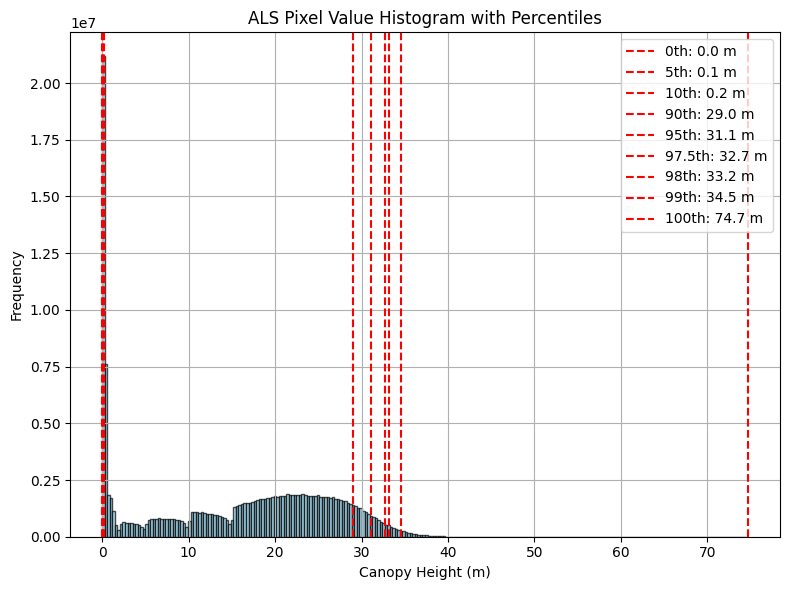

In [27]:
plot_ALS_histogram(ALS_PATH1_P)
plot_ALS_histogram(ALS_PATH2_P)

## Sentinel-2 (S2) data ingest and pre-processing

### Conversion to .vrt in order to handle each band nicely

In [3]:
# === CONFIG ===
root_dir = S2_PATH1
recursive = True                   # Set to False if you don't want recursion
vrt_output_dir = VRT_FOLDER        # Where to save the VRTs

# === STEP 1: Gather all .tif files ===
tif_files = []
for root, _, files in os.walk(root_dir):
    for f in files:
        if f.lower().endswith('.tif'):
            tif_files.append(os.path.join(root, f))
    if not recursive:
        break

# === STEP 2: Group files by band suffix ===
band_groups = defaultdict(list)

pattern = re.compile(r"_SEN2L_(.+?)\.tif$", re.IGNORECASE)
for f in tif_files:
    match = pattern.search(os.path.basename(f))
    if match:
        band = match.group(1)  # e.g., "BLU_STM"
        band_groups[band].append(f)
        #print(f"Found {band} file: {f}")

if False:
# === STEP 3: Create VRTs using gdalbuildvrt ===
    for band, files in band_groups.items():
        vrt_path = os.path.join(vrt_output_dir, f"{band}.vrt")
        print(f"Creating {band} with {len(files)} files...")

        # Write file list
        list_path = os.path.join(vrt_output_dir, f"list_{band}.txt")
        with open(list_path, "w") as f:
            for tif in files:
                f.write(f"{tif}\n")

        # Call gdalbuildvrt
        subprocess.run([
            "gdalbuildvrt",
            "-input_file_list", list_path,
            vrt_path
        ], check=True)

        os.remove(list_path)

    print("✅ Done! One VRT per band has been created.")
    #print(band_groups.keys())  # print the keys of the band groups


### Align the S2 to ALS data

how to do alignment:
- first, we have to check for the same Map Projection.
- alignment and cropping:
    - polygon cutline around the images: downside: is very memory heavy (30GB)
    - instead, we crop an outer bounding box over the overlapping area for each ALS Site. 
- then, later we can drop parts where not all layers have plausible pixel values

### check projections

In [9]:
# check the projection of s2 and als 
def check_projection(als_path, vrt_path):
    """
    Check if the projections of ALS and VRT files match.
    """
    with rasterio.open(als_path) as als_src:
        als_crs = als_src.crs
        als_transform = als_src.transform

    with rasterio.open(vrt_path) as vrt_src:
        vrt_crs = vrt_src.crs
        vrt_transform = vrt_src.transform

    if als_crs == vrt_crs:
        print("✅ CRS Projections match!")
    else:
        print("❌ CRS Projections do not match!")

    print(f"ALS CRS: {als_crs}")
    print(f"VRT CRS: {vrt_crs}")

    if als_transform == vrt_transform:
        print("✅ Transformations match!")
    else:
        print("❌ Transformations do not match!")
    print("ALS Transform:", als_transform)
    print("VRT Transform:", vrt_transform)
    
check_projection(ALS_PATH1_P, os.path.join(VRT_FOLDER, "RED_STM.vrt"))

✅ CRS Projections match!
ALS CRS: EPSG:25832
VRT CRS: EPSG:25832
❌ Transformations do not match!
ALS Transform: | 0.50, 0.00, 601191.00|
| 0.00,-0.50, 5528384.50|
| 0.00, 0.00, 1.00|
VRT Transform: | 10.00, 0.00, 388279.44|
| 0.00,-10.00, 5628053.30|
| 0.00, 0.00, 1.00|


**🆒, both share the same coordinate system. the two diff. transformation, we'll take of that later when doing the resampling.**

### do bounding box cropping

In [10]:

def crop_and_stack_vrts_to_als(
    als_path, 
    vrt_folder, 
    site_index=1, 
    override=False
):
    """
    Crop and stack all VRT bands to the bounding box of a single ALS raster.

    Args:
        als_path (str): Path to the ALS raster (used for bounding box and CRS).
        vrt_folder (str): Folder containing the VRT files.
        site_index (int): Index of the site (for naming).
        override (bool): If True, overwrite existing files.
    """

    # Get bounding box and CRS from ALS raster
    with rasterio.open(als_path) as src:
        bounds = src.bounds
        crs = src.crs

    vrt_files = glob.glob(os.path.join(vrt_folder, "*.vrt"))

    sitefolder = os.path.join(vrt_folder, f"site_{site_index}")
    if not os.path.exists(sitefolder):
        os.makedirs(sitefolder)

    for vrt in vrt_files:
        band_name = os.path.splitext(os.path.basename(vrt))[0]
        output_tif = os.path.join(
            sitefolder, f"{band_name}_cropped.tif"
        )

        if os.path.exists(output_tif) and not override:
            print(f"[SKIP] {output_tif} already exists.")
            continue

        print(f"[WARP] Cropping {band_name} for site {site_index}...")

        cmd = [
            "gdalwarp",
            "-te", str(bounds.left), str(bounds.bottom), str(bounds.right), str(bounds.top),
            "-te_srs", crs.to_string(),
            "-of", "GTiff",
            "-overwrite",
            vrt,
            output_tif
        ]

        try:
            subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        except subprocess.CalledProcessError as e:
            print(f"[ERROR] gdalwarp failed for {band_name}")
            print(e.stderr.decode())

    print(f"\n✅ All VRTs processed and cropped for site {site_index}.")

# Crop and stack VRTs to ALS
crop_and_stack_vrts_to_als(ALS_PATH1, VRT_FOLDER, site_index=1, override=False)
crop_and_stack_vrts_to_als(ALS_PATH2, VRT_FOLDER, site_index=2, override=False)

[SKIP] ../data/02_processed/S2_VRT/site_1/RED_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/EVI_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/NDV_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/GRN_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/SW1_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/RE1_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/NBR_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/BLU_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/NIR_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/RE3_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/SW2_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/BNR_STM_cropped.tif already exists.
[SKIP] ../data/02_processed/S2_VRT/site_1/RE2_STM_cropped.tif al

### stack the cropped S2 vrts back into one tif with 13 channels

In [21]:
# stack them together into a single multiband TIFF per site, keep the band names

def stack_site_vrts_to_multiband(site_index, vrt_folder, output_folder, override=False):
    """
    Stacks all cropped VRT bands for a given site into a single multiband TIFF.

    Args:
        site_index (int): Index of the site (e.g., 1 or 2).
        vrt_folder (str): Path to the VRT folder containing site subfolders.
        output_folder (str): Path to save the stacked multiband TIFF.
        override (bool): If True, overwrite existing stacked file.
    Returns:
        str: Path to the stacked multiband TIFF.
    """

    sitefolder = os.path.join(vrt_folder, f"site_{site_index}")
    if not os.path.exists(sitefolder):
        raise FileNotFoundError(f"Site folder not found: {sitefolder}")

    band_tifs = sorted(glob.glob(os.path.join(sitefolder, "*_cropped.tif")))
    if not band_tifs:
        raise FileNotFoundError(f"No cropped band TIFFs found in {sitefolder}")

    #print(f"Found {len(band_tifs)} cropped band TIFFs for site {site_index}.")
    #print("Band TIFFs:", band_tifs)
    stacked_output = os.path.join(output_folder, f"S2_Stacked_Site_{site_index}.tif")

    def stack_bands(band_paths, out_path):
        # Extract band names (e.g., BLU from .../BLU_STM_cropped.tif)
        band_names = [os.path.basename(p).split('_')[0] for p in band_paths]
        with rasterio.open(band_paths[0]) as sample:
            meta = sample.meta.copy()
            meta.update(count=len(band_paths))
            # Set band descriptions
            meta["descriptions"] = tuple(band_names)
            with rasterio.open(out_path, 'w', **meta) as dst:
                for i, (path, band_name) in enumerate(zip(band_paths, band_names), start=1):
                    with rasterio.open(path) as src:
                        dst.write(src.read(1), i)
                        dst.set_band_description(i, band_name)
        print(f"✅ Stacked {len(band_paths)} bands into {out_path}")
        return out_path
    # Check if stacked file already exists
    # If it exists and override is False, return the existing file path
    # If it does not exist or override is True, stack the bands into a new file

    if os.path.exists(stacked_output) and not override:
        print(f"✅ Loaded existing stacked file: {stacked_output}")
        return stacked_output
    else:
        print(f"⚙️ Stacked file not found or override requested. Creating new stack...")
        return stack_bands(band_tifs, stacked_output)


In [24]:
# Stack VRTs to multiband
S2_stacked_1 = stack_site_vrts_to_multiband(1, VRT_FOLDER, OUTPUT_FOLDER, override=True)
S2_stacked_2 = stack_site_vrts_to_multiband(2, VRT_FOLDER, OUTPUT_FOLDER, override=True)

⚙️ Stacked file not found or override requested. Creating new stack...
✅ Stacked 13 bands into ../data/02_processed/S2_Stacked_Site_1.tif
⚙️ Stacked file not found or override requested. Creating new stack...
✅ Stacked 13 bands into ../data/02_processed/S2_Stacked_Site_2.tif


In [25]:
# test if band names are correct
with rasterio.open(S2_stacked_1) as s2_src:
    s2np = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
    s2res_x, s2res_y = s2_src.res  # (pixel width, pixel height in coordinate units)
    s2crs = s2_src.crs
    # Print band (channel) descriptions if available
    print(s2_src.descriptions)

('BLU', 'BNR', 'EVI', 'GRN', 'NBR', 'NDV', 'NIR', 'RE1', 'RE2', 'RE3', 'RED', 'SW1', 'SW2')


## Now, we're ready for resampling

### loading the rasters first and check the GSD 

In [9]:
# load the stacked S2 and merged ALS rasters
def load_rasters(S2_stack_path, ALS_Path, verbose=True):
    """
    Load Sentinel-2 stacked raster and ALS raster, print their properties.
    Args:
        S2_stack_path (str): Path to the Sentinel-2 stacked raster.
        ALS_Path (str): Path to the ALS raster.
        verbose (bool): If True, print additional information.
    Returns:
        tuple: Numpy arrays of the S2 and ALS rasters.
    """
    
    with rasterio.open(S2_stack_path) as s2_src:
        s2np = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
        s2res_x, s2res_y = s2_src.res  # (pixel width, pixel height in coordinate units)
        s2crs = s2_src.crs
    
    with rasterio.open(ALS_Path) as src1:
        alsnp = src1.read(1).astype(np.float32)  # shape: (height, width)
        ares_x, ares_y = src1.res  # (pixel width, pixel height in coordinate units)
        acrs = src1.crs

    if verbose:
        print(f"✅ Loaded S2: {s2np.shape}, ALS: {alsnp.shape}")

        print(f"{os.path.basename(S2_stack_path)}:")
        print(f"  CRS: {s2crs}")
        print(f"  Ground Sampling Distance (GSD): {s2res_x:.2f} x {s2res_y:.2f} {s2crs.linear_units}\n")

        print(f"{os.path.basename(ALS_Path)}:")
        print(f"  CRS: {acrs}")
        print(f"  Ground Sampling Distance (GSD): {ares_x:.2f} x {ares_y:.2f} {acrs.linear_units}\n")

    return s2np, alsnp #, s2_src, alsnp

# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np = load_rasters(S2_stacked_1, ALS_PATH1_P)
s2_np2, als_np2 = load_rasters(S2_stacked_2, ALS_PATH2_P)

# # do one file with both sites but give them a new dimension
# s2_combined = np.stack([s2_np, s2_np2], axis=0)  # shape: (sites, bands, height, width)
# als_combined = np.stack([als_np, als_np2], axis=0)  # shape: (sites, height, width)

✅ Loaded S2: (13, 846, 1241), ALS: (16910, 24821)
S2_Stacked_Site_1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

ALS_GT01_2024_processed.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 0.50 x 0.50 metre

✅ Loaded S2: (13, 1002, 815), ALS: (20040, 16291)
S2_Stacked_Site_2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre

ALS_GT02_2024_processed.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 0.50 x 0.50 metre



💡 We still have the same CRS, however GSD is not the same, we'll tackle this now

### Now let's to the resampling.
Since rasterio doesnt provide a percentile resampling method, we do the following:
1. Take the preprocessed ALS data (outlier already removed, values are in range[0,75])
2. Clip (=saturate) the upper end above the 98th (can be parametrized) percentile.
3. Then, use Rasterio.Resampling and use the method ‚max'. Since it only takes max, mean, median, etc. but no custom quantiles, let’s just do this step manually beforehand. Only downside is, that we clip at the overall 98th percentile of the whole image, not for each window (20x20=400 pixel per 10x10m). However, if the goal is to filter out scatter/noise, this should be fine for a first approach, the error is probably negligible.

[See Rasterio Resampling documentation](https://rasterio.readthedocs.io/en/latest/topics/resampling.html) 


In [47]:
# (old) global approach for resampling ALS to S2

def resample_ALS_to_S2_global_clipping(als_path, s2_path, percentile=98):
    # Open S2 stack to get shape, transform, and CRS
    with rasterio.open(s2_path) as s2_src:
        s2_shape = (s2_src.height, s2_src.width)
        s2_transform = s2_src.transform
        s2_crs = s2_src.crs

    # Open ALS raster
    with rasterio.open(als_path) as als_src:
        als_data = als_src.read(1).astype(np.float32)
        # Calculate the x-th percentile and clip upper values
        als_data[als_data <= 0] = np.nan  # Set negative values to NaN
        perc = np.percentile(als_data[~np.isnan(als_data)], percentile)
        #perc = np.percentile(als_data, percentile)
        als_data = np.clip(als_data, None, perc)

        als_transform = als_src.transform 
        als_crs = als_src.crs

        # Prepare output array
        als_resampled = np.full(s2_shape, np.nan, dtype=np.float32)

        # Use rasterio's reproject with max aggregation to downsample
        reproject(
            source=als_data,
            destination=als_resampled,
            src_transform=als_transform,
            src_crs=als_crs,
            dst_transform=s2_transform,
            dst_crs=s2_crs,
            resampling=Resampling.max
        )
        als_resampled[als_resampled <= 0] = np.nan  # Set negative values to NaN
    print(f"✅ Resampled ALS to S2 shape: {als_resampled.shape}, S2 shape: {s2_shape}; percentile: {percentile}th")
    return als_resampled

#als_resampled = resample_ALS_to_S2_global_clipping(ALS_PATH1_P, S2_stacked_1, percentile=98)

In [48]:
# Block-wise percentile clipping, this is the way to go.
# This function resamples ALS to S2 resolution, clipping upper values at a given percentile.

def resample_ALS_to_S2(als_path, s2_path, percentile=98):
    # Open S2 stack to get shape, transform, and CRS
    with rasterio.open(s2_path) as s2_src:
        s2_shape = (s2_src.height, s2_src.width)
        s2_transform = s2_src.transform
        s2_crs = s2_src.crs

    # Open ALS raster
    with rasterio.open(als_path) as als_src:
        als_data = als_src.read(1).astype(np.float32)
        # Calculate the x-th percentile and clip upper values
        als_data[als_data <= 0] = np.nan  # Set negative values to NaN
        # Moving window (20x20) percentile clipping
        # Block-wise processing: process ALS in 20x20 blocks, clip each block at the local percentile
        block_size = 20
        h, w = als_data.shape
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = als_data[i:i+block_size, j:j+block_size]
            if np.all(np.isnan(block)):
                continue
            perc = np.nanpercentile(block, percentile)
            als_data[i:i+block_size, j:j+block_size] = np.clip(block, None, perc)

        als_transform = als_src.transform 
        als_crs = als_src.crs

        # Prepare output array
        als_resampled = np.full(s2_shape, np.nan, dtype=np.float32)

        # Use rasterio's reproject with max aggregation to downsample
        reproject(
            source=als_data,
            destination=als_resampled,
            src_transform=als_transform,
            src_crs=als_crs,
            dst_transform=s2_transform,
            dst_crs=s2_crs,
            resampling=Resampling.max
        )
        als_resampled[als_resampled <= 0] = np.nan  # Set negative values to NaN
    print(f"✅ Resampled ALS to S2 shape: {als_resampled.shape}, S2 shape: {s2_shape}; percentile: {percentile}th")
    return als_resampled

In [ ]:
als_resampled1 = resample_ALS_to_S2(ALS_PATH1_P, S2_stacked_1, percentile=98)
als_resampled2 = resample_ALS_to_S2(ALS_PATH2_P, S2_stacked_2, percentile=98)

In [51]:
#print the count of nan in the resampled ALS data
print(f"ALS Resampled 1 NaN count: {np.isnan(als_resampled1).sum()}")
print(f"ALS Resampled 2 NaN count: {np.isnan(als_resampled2).sum()}")

ALS Resampled 1 NaN count: 551421
ALS Resampled 2 NaN count: 372580


In [24]:
# write the resampled ALS to a new file
def write_resampled_als(als_data, s2_path, output_path):
    """
    Write the resampled ALS data to a new TIFF file.
    
    Args:
        als_data (np.ndarray): Resampled ALS data.
        s2_path (str): Path to the S2 stack for metadata.
        output_path (str): Path to save the resampled ALS TIFF.
    """
    with rasterio.open(s2_path) as s2_src:
        profile = s2_src.profile.copy()
        profile.update(
            dtype=rasterio.float32,
            count=1,
            nodata=np.nan
        )

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(als_data, 1)

    print(f"✅ Resampled ALS saved to: {output_path}")
    return output_path

ALS_PATH1_RES = write_resampled_als(als_resampled1, S2_stacked_1, os.path.join(OUTPUT_FOLDER, "ALS_resampled_site1.tif"))
ALS_PATH2_RES = write_resampled_als(als_resampled2, S2_stacked_2, os.path.join(OUTPUT_FOLDER, "ALS_resampled_site2.tif"))

✅ Resampled ALS saved to: ../data/02_processed/ALS_resampled_site1.tif
✅ Resampled ALS saved to: ../data/02_processed/ALS_resampled_site2.tif


cool, now that we have two spatially aligned images with the same resolution, we can dig deeper. let's have some insights into our data. --> see 02_data_insights
